# Import necessary Libraries 


In [1]:
!pip3 install xgboost

In [2]:
pip install plotly

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import (train_test_split,KFold)
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import datetime as dt
from statsmodels.tsa.arima_model import ARIMA
import xgboost as xgb

# Examining Data

In [4]:
df=pd.read_csv("train 2.csv",parse_dates=['date'])
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [6]:
#Checking null values
df.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [7]:
# Checking data types
df.dtypes

date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

In [8]:
#Cheking shape
df.shape

(913000, 4)

In [9]:
df['sales'].describe([0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,0.95])

count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
10%          20.000000
20%          26.000000
30%          33.000000
40%          40.000000
50%          47.000000
60%          55.000000
70%          64.000000
80%          76.000000
90%          93.000000
95%         107.000000
max         231.000000
Name: sales, dtype: float64

In [10]:
#checking dates range
df.date.max()

Timestamp('2017-12-31 00:00:00')

In [11]:
df.date.min()

Timestamp('2013-01-01 00:00:00')

In [12]:
df.date.max()-df.date.min()

Timedelta('1825 days 00:00:00')

In [13]:
#feature engineering


In [14]:
df["year"]=df.date.dt.year
df['month'] = df.date.dt.month
df['day_of_year'] = df.date.dt.dayofyear
df['week_of_year'] = df.date.dt.weekofyear 
df['day_of_week'] = df.date.dt.dayofweek
df["is_wknd"] = df.date.dt.weekday
df['is_month_start'] = df.date.dt.is_month_start.astype(int) 
df['is_month_end'] = df.date.dt.is_month_end.astype(int)
df['is_quarter_start'] = df['date'].dt.is_quarter_start
df['is_quarter_end'] = df['date'].dt.is_quarter_end
df['is_year_start'] = df['date'].dt.is_year_start
df['is_year_end'] = df['date'].dt.is_year_end
df.head()

<ipython-input-14-5b45b867df1f>:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week_of_year'] = df.date.dt.weekofyear


,date,store,item,sales,year,month,day_of_year,week_of_year,day_of_week,is_wknd,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end
0,2013-01-01,1,1,13,2013,1,1,1,1,1,1,0,True,False,True,False
1,2013-01-02,1,1,11,2013,1,2,1,2,2,0,0,False,False,False,False
2,2013-01-03,1,1,14,2013,1,3,1,3,3,0,0,False,False,False,False
3,2013-01-04,1,1,13,2013,1,4,1,4,4,0,0,False,False,False,False
4,2013-01-05,1,1,10,2013,1,5,1,5,5,0,0,False,False,False,False


In [15]:
#daily , monthly, average
df['daily_avg']=df.groupby(['item','store','day_of_week'])['sales'].transform('mean')
df['monthly_avg']=df.groupby(['item','store','month'])['sales'].transform('mean')
df.head()

,date,store,item,sales,year,month,day_of_year,week_of_year,day_of_week,is_wknd,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,daily_avg,monthly_avg
0,2013-01-01,1,1,13,2013,1,1,1,1,1,1,0,True,False,True,False,18.168582,13.709677
1,2013-01-02,1,1,11,2013,1,2,1,2,2,0,0,False,False,False,False,18.793103,13.709677
2,2013-01-03,1,1,14,2013,1,3,1,3,3,0,0,False,False,False,False,19.452107,13.709677
3,2013-01-04,1,1,13,2013,1,4,1,4,4,0,0,False,False,False,False,21.015326,13.709677
4,2013-01-05,1,1,10,2013,1,5,1,5,5,0,0,False,False,False,False,22.973180,13.709677


Text(0, 0.5, 'sales frequency')

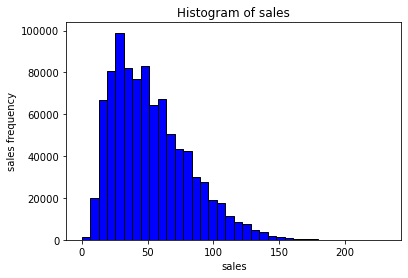

In [16]:
plt.hist(df['sales'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))


plt.title('Histogram of sales')
plt.xlabel('sales')
plt.ylabel('sales frequency')
#skewed to the right 

In [17]:
df['store_item_shifted_365'] = df.groupby(["item","store"])['sales'].transform(lambda x:x.shift(1))
df.head(50)

,date,store,item,sales,year,month,day_of_year,week_of_year,day_of_week,is_wknd,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,daily_avg,monthly_avg,store_item_shifted_365
0,2013-01-01,1,1,13,2013,1,1,1,1,1,1,0,True,False,True,False,18.168582,13.709677,NaN
1,2013-01-02,1,1,11,2013,1,2,1,2,2,0,0,False,False,False,False,18.793103,13.709677,13.0
2,2013-01-03,1,1,14,2013,1,3,1,3,3,0,0,False,False,False,False,19.452107,13.709677,11.0
3,2013-01-04,1,1,13,2013,1,4,1,4,4,0,0,False,False,False,False,21.015326,13.709677,14.0
4,2013-01-05,1,1,10,2013,1,5,1,5,5,0,0,False,False,False,False,22.973180,13.709677,13.0
5,2013-01-06,1,1,12,2013,1,6,1,6,6,0,0,False,False,False,False,23.796935,13.709677,10.0
6,2013-01-07,1,1,10,2013,1,7,2,0,0,0,0,False,False,False,False,15.584615,13.709677,12.0
7,2013-01-08,1,1,9,2013,1,8,2,1,1,0,0,False,False,False,False,18.168582,13.709677,10.0
8,2013-01-09,1,1,12,2013,1,9,2,2,2,0,0,False,False,False,False,18.793103,13.709677,9.0
9,2013-01-10,1,1,9,2013,1,10,2,3,3,0,0,False,False,False,False,19.452107,13.709677,12.0


In [18]:
# shifted total sales for 12 week or 90 days
df["item-week_shifted_90"] = df.groupby(['week_of_year',"item"])["sales"].transform(lambda x:x.shift(12).sum())
df.head(55)

,date,store,item,sales,year,month,day_of_year,week_of_year,day_of_week,is_wknd,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,daily_avg,monthly_avg,store_item_shifted_365,item-week_shifted_90
0,2013-01-01,1,1,13,2013,1,1,1,1,1,1,0,True,False,True,False,18.168582,13.709677,NaN,4882
1,2013-01-02,1,1,11,2013,1,2,1,2,2,0,0,False,False,False,False,18.793103,13.709677,13.0,4882
2,2013-01-03,1,1,14,2013,1,3,1,3,3,0,0,False,False,False,False,19.452107,13.709677,11.0,4882
3,2013-01-04,1,1,13,2013,1,4,1,4,4,0,0,False,False,False,False,21.015326,13.709677,14.0,4882
4,2013-01-05,1,1,10,2013,1,5,1,5,5,0,0,False,False,False,False,22.973180,13.709677,13.0,4882
5,2013-01-06,1,1,12,2013,1,6,1,6,6,0,0,False,False,False,False,23.796935,13.709677,10.0,4882
6,2013-01-07,1,1,10,2013,1,7,2,0,0,0,0,False,False,False,False,15.584615,13.709677,12.0,4998
7,2013-01-08,1,1,9,2013,1,8,2,1,1,0,0,False,False,False,False,18.168582,13.709677,10.0,4998
8,2013-01-09,1,1,12,2013,1,9,2,2,2,0,0,False,False,False,False,18.793103,13.709677,9.0,4998
9,2013-01-10,1,1,9,2013,1,10,2,3,3,0,0,False,False,False,False,19.452107,13.709677,12.0,4998


In [19]:
fig=px.line('item-week_shifted_90',x='sales', y='date')
fig.show()

NameError: name 'px' is not defined

In [20]:
daily_avg=df.groupby(['item','store','day_of_week'])['sales'].mean()
monthly_avg=df.groupby(['item','store','month'])['sales'].mean()
item_month_sum=df.groupby(['month','item'])['sales'].sum()


In [ ]:
f = plt.figure(figsize=(19, 20))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)

In [ ]:
import plotly.offline as pyo
pyo.init_notebook_mode()
daily_sales = df.groupby('date', as_index=False)['sales'].sum()
store_daily_sales = df.groupby(['store', 'date'], as_index=False)['sales'].sum()
item_daily_sales = df.groupby(['item', 'date'], as_index=False)['sales'].sum()

In [ ]:
u

In [ ]:
df.dtypes

In [21]:
df['store_item_shifted_365'].fillna(df['store_item_shifted_365'].mode()[0], inplace=True)
df['daily_avg']= df['daily_avg'].astype(int)
df['store_item_shifted_365']=df['store_item_shifted_365'].astype(int)
df.dtypes

date                      datetime64[ns]
store                              int64
item                               int64
sales                              int64
year                               int64
month                              int64
day_of_year                        int64
week_of_year                       int64
day_of_week                        int64
is_wknd                            int64
is_month_start                     int32
is_month_end                       int32
is_quarter_start                    bool
is_quarter_end                      bool
is_year_start                       bool
is_year_end                         bool
daily_avg                          int32
monthly_avg                      float64
store_item_shifted_365             int32
item-week_shifted_90               int64
dtype: object

In [ ]:
#rolling mean
roll_mean = df.rolling(window=12, center=False).mean()
roll_std = df.rolling(window=12, center=False).std()
print(roll_mean)
print(roll_std)

In [ ]:
mean= plt.plot(roll_mean,color='red',label='Rolling mean') 
std=plt.plot(roll_std,color='black',label='Rolling Std')
plt.legend(loc='best')
plt.show

In [ ]:
import statsmodels.tsa.stattools as tsa
df1=df.drop(['date', 'is_quarter_start','is_quarter_end', 'is_year_start','is_year_end'], axis=1)
df1.dtypes
adf_results = {}
for col in df1.columns.values:  
    adf_results[col] = tsa.adfuller(df1[col])
print(adf_results)

#df1=df.drop(['date', 'is_quarter_start','is_quarter_end', 'is_year_start','is_year_start'], axis=1)
#x=adfuller(df1)
#print(x[0])

In [22]:
df.set_index('date')

,store,item,sales,year,month,day_of_year,week_of_year,day_of_week,is_wknd,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,daily_avg,monthly_avg,store_item_shifted_365,item-week_shifted_90
date,,,,,,,,,,,,,,,,,,,
2013-01-01,1,1,13,2013,1,1,1,1,1,1,0,True,False,True,False,18,13.709677,30,4882
2013-01-02,1,1,11,2013,1,2,1,2,2,0,0,False,False,False,False,18,13.709677,13,4882
2013-01-03,1,1,14,2013,1,3,1,3,3,0,0,False,False,False,False,19,13.709677,11,4882
2013-01-04,1,1,13,2013,1,4,1,4,4,0,0,False,False,False,False,21,13.709677,14,4882
2013-01-05,1,1,10,2013,1,5,1,5,5,0,0,False,False,False,False,22,13.709677,13,4882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,10,50,63,2017,12,361,52,2,2,0,0,False,False,False,False,68,56.283871,41,16658
2017-12-28,10,50,59,2017,12,362,52,3,3,0,0,False,False,False,False,73,56.283871,63,16658
2017-12-29,10,50,74,2017,12,363,52,4,4,0,0,False,False,False,False,78,56.283871,59,16658


In [ ]:
# Plotting Trends for Each item

df.plot(figsize=(18,12))
plt.title('Sales Trends Between 2013-2017', fontsize=22)
plt.xlabel('date', fontsize=20)
plt.ylabel('sales', fontsize=20)
plt.legend(bbox_to_anchor=[1,1])
plt.show();

In [ ]:
#Creating new features to analyse items against year, week, month
df["year"]=df.index.dt.year
#df['month'] = df.index.month
#df['day_of_year'] = df.index.dayofyear
#df['week_of_year'] = df.index.weekofyear 
#df['day_of_week'] = df.index.dayofweek
#df["is_wknd"] = df.index.weekday
#df['is_month_start'] = df.date.dt.is_month_start.astype(int) 
#df['is_month_end'] = df.date.dt.is_month_end.astype(int)
#kdf.head()

In [ ]:
#Dropping stores as it is uneccssary for problem 
df=df.drop(["store"],axis=1)
df.head(20)

In [ ]:
df.set_index('date')

In [ ]:
df['is_month_start'] = df['is_month_start'].replace({True: 1, False: 0})
df['is_month_end'] = df['is_month_end'].replace({True: 1, False: 0})
df['is_quarter_start'] = df['is_quarter_start'].replace({True: 1, False: 0})
df['is_quarter_end'] = df['is_quarter_end'].replace({True: 1, False: 0})
df['is_year_start'] = df['is_year_start'].replace({True: 1, False: 0})
df['is_year_end'] = df['is_year_end'].replace({True: 1, False: 0})

#convert float to int
df['daily_avg']=df['daily_avg'].astype(np.int64)

In [23]:
#Isolating only item 1 to work on prediction 
filt1=(df['item']==1)
df1=df[filt1]
df1.head()

,date,store,item,sales,year,month,day_of_year,week_of_year,day_of_week,is_wknd,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,daily_avg,monthly_avg,store_item_shifted_365,item-week_shifted_90
0,2013-01-01,1,1,13,2013,1,1,1,1,1,1,0,True,False,True,False,18,13.709677,30,4882
1,2013-01-02,1,1,11,2013,1,2,1,2,2,0,0,False,False,False,False,18,13.709677,13,4882
2,2013-01-03,1,1,14,2013,1,3,1,3,3,0,0,False,False,False,False,19,13.709677,11,4882
3,2013-01-04,1,1,13,2013,1,4,1,4,4,0,0,False,False,False,False,21,13.709677,14,4882
4,2013-01-05,1,1,10,2013,1,5,1,5,5,0,0,False,False,False,False,22,13.709677,13,4882


In [24]:
df1.set_index('date', inplace=True)
df1.head()

,store,item,sales,year,month,day_of_year,week_of_year,day_of_week,is_wknd,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,daily_avg,monthly_avg,store_item_shifted_365,item-week_shifted_90
date,,,,,,,,,,,,,,,,,,,
2013-01-01,1,1,13,2013,1,1,1,1,1,1,0,True,False,True,False,18,13.709677,30,4882
2013-01-02,1,1,11,2013,1,2,1,2,2,0,0,False,False,False,False,18,13.709677,13,4882
2013-01-03,1,1,14,2013,1,3,1,3,3,0,0,False,False,False,False,19,13.709677,11,4882
2013-01-04,1,1,13,2013,1,4,1,4,4,0,0,False,False,False,False,21,13.709677,14,4882
2013-01-05,1,1,10,2013,1,5,1,5,5,0,0,False,False,False,False,22,13.709677,13,4882


In [26]:
df1=df.drop(['date', 'is_quarter_start','is_quarter_end', 'is_year_start','is_year_end'], axis=1)
df1.head()

,store,item,sales,year,month,day_of_year,week_of_year,day_of_week,is_wknd,is_month_start,is_month_end,daily_avg,monthly_avg,store_item_shifted_365,item-week_shifted_90
0,1,1,13,2013,1,1,1,1,1,1,0,18,13.709677,30,4882
1,1,1,11,2013,1,2,1,2,2,0,0,18,13.709677,13,4882
2,1,1,14,2013,1,3,1,3,3,0,0,19,13.709677,11,4882
3,1,1,13,2013,1,4,1,4,4,0,0,21,13.709677,14,4882
4,1,1,10,2013,1,5,1,5,5,0,0,22,13.709677,13,4882


In [28]:
df1.isna().sum()

store                     0
item                      0
sales                     0
year                      0
month                     0
day_of_year               0
week_of_year              0
day_of_week               0
is_wknd                   0
is_month_start            0
is_month_end              0
daily_avg                 0
monthly_avg               0
store_item_shifted_365    0
item-week_shifted_90      0
dtype: int64

#### from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(np.log(df1))

In [ ]:
df1.plot(kind='line', figsize=(12,8), label='Item1')

In [ ]:
#df test and p value
from statsmodels.tsa.stattools import adfuller
X=df1['sales'].values
result=adfuller(X)
print(result[1])

In [ ]:
result1=adfuller(np.log(X))
print(result1[1])

In [ ]:
result2=adfuller(np.sqrt(X))
print(result2[1])

In [ ]:
result3=adfuller(np.cbrt(X))
print(result3[1])

In [ ]:
X.info

In [ ]:
df1['is_month_start'] = df1['is_month_start'].replace({True: 1, False: 0})
df1['is_month_end'] = df1['is_month_end'].replace({True: 1, False: 0})
df1['is_quarter_start'] = df1['is_quarter_start'].replace({True: 1, False: 0})
df1['is_quarter_end'] = df1['is_quarter_end'].replace({True: 1, False: 0})
df1['is_year_start'] = df1['is_year_start'].replace({True: 1, False: 0})
df1['is_year_end'] = df1['is_year_end'].replace({True: 1, False: 0})

#convert float to int
df1['daily_avg']=df1['daily_avg'].astype(np.int64)
df1['monthly_avg']=df1['monthly_avg'].astype(np.int64)
df.dtypes

In [ ]:
df1['store_item_shifted_365'].fillna(df1['store_item_shifted_365'].mode()[0], inplace=True)
df1['store_item_shifted_365']=df1['store_item_shifted_365'].astype(np.int64)
df1.dtypes

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Decomposition
def decomposition_plot(X):
# Apply seasonal_decompose 
    decomposition = seasonal_decompose(np.log(X))
    
# Get trend, seasonality, and residuals
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

# Plotting
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(np.log(ts), label='Original', color='blue')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    plt.tight_layout()

In [ ]:
df1.info
df1.dropna(axis=1)

In [ ]:
seasonal_decompose(np.log(df1))

In [ ]:
#Item 1 for 5 years 
df1['year'].value_counts()

In [ ]:
#Similar value for each month 
df.loc[filt1]['month'].value_counts()

In [ ]:
['day_of_year'].value_counts()

In [ ]:
df.loc[filt1].week_of_year.value_counts()

In [ ]:
df.loc[filt1].describe()

In [ ]:
#indicates equal sales happens during all the days of a week
df.is_wknd.value_counts()

In [ ]:
df.week_of_year.value_counts()

In [ ]:
df1.groupby(['year','sales']).sum()

In [ ]:
cols_plot=['sales'['']]

In [ ]:
#item1=(df.groupby(['date','sales']).sum())
#item1

In [ ]:
#df["year"]=df.date.dt.year
#df['month'] = df.date.dt.month
#df['day_of_year'] = df.date.dt.dayofyear
#df['week_of_year'] = df.date.dt.weekofyear 
#df['day_of_week'] = df.date.dt.dayofweek
#df["is_wknd"] = df.date.dt.weekday
#df['is_month_start'] = df.date.dt.is_month_start.astype(int) 
#df['is_month_end'] = df.date.dt.is_month_end.astype(int)
df.loc['2013','sales'].plot()

In [ ]:
#df.groupby(['sales','item']).agg('count')

In [ ]:
df.store.unique()

In [ ]:
df.isnull().sum()

In [ ]:
#df['sales'].describe([0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,0.95])

In [ ]:
#looking at sales distribution
#n, bins, patches = plt.hist(x=df1['sales'],rwidth=0.8)
#plt.xlabel('sales')
#plt.ylabel('Frequency')

In [ ]:
#df.groupby(["store","item"]).agg({"sales": ["sum"]})

In [ ]:
#df.groupby(["store","item"]).agg({"sales": ["sum","mean","std","median"]})

In [ ]:
def create_date_features(df):
    # Since we have converted 'date' column into 'Date Format' we are allowed to use the methods that we see below(like : date.dt.month,day,year etc.) 
    df['month'] = df.date.dt.month # Which month of the corresponding year
    df['day_of_month'] = df.date.dt.day # Which day of the corresponding month
    df['day_of_year'] = df.date.dt.dayofyear # Which day of the corresponding year
    df['week_of_year'] = df.date.dt.weekofyear # Which week of the corresponding year
    df['day_of_week'] = df.date.dt.dayofweek # Which day of the corresponding week of the each month
    df['year'] = df.date.dt.year # Which year
    df["is_wknd"] = df.date.dt.weekday // 4 # df.date.dt.weekday => Starts from '0' means '0' = 'Monday'. So, '// 4' will give '1' when day number equals
    # to '5'(which corresponds 'Saturday') and '6'(which corresponds 'Sunday') and '0' for rest of them. Consequently this column will represent whether 
    # the day is weekend or not
    df['is_month_start'] = df.date.dt.is_month_start.astype(int) # Is it starting of the corresponding month
    df['is_month_end'] = df.date.dt.is_month_end.astype(int) # Is it ending of the corresponding month
    return df

In [ ]:
df.head()

In [ ]:
df.dtypes

In [ ]:

df.groupby(["store","item"]).agg({"sales": ["sum"]})

In [ ]:
#Dropping stores as it is uneccssary for problem 
df1=df.drop(["store"],axis=1)
df1.head()

In [ ]:
df1["year"]=df1.date.dt.year
df1.head(50)

In [ ]:
#Using filter to analyse only item 1
filt=(df1['item']==1)
df1[filt]

In [ ]:
#Item 1 for 5 years 
df1.loc[filt]['year'].value_counts()

In [ ]:
df1.groupby(['item','year']).sum.loc[:5]

In [ ]:
df1.groupby(["year",""]).agg({"sales": ["sum", "mean","std","median"]}).head(50)

In [ ]:
df.year.value_counts()
#indicates year on year no significant change in total sales of all 50 items 

In [ ]:
#indicates 75% sales happens during weekend
df.is_wknd.value_counts()

In [ ]:
df.week_of_year.value_counts()

In [ ]:
df1=df.drop("store", axis=1)
df1.head()

In [ ]:
df.groupby(["year", "item"]).agg({"sales": ["sum"]})

In [ ]:
#mean and median is not far away from each other 
df.groupby(["year", "item"]).agg({"sales": ["sum", "mean","std","median"]}).head(50)

In [ ]:
df.groupby(["year", "item"]).agg({"sales": ["sum"]}).plot()

In [ ]:
filt=(df['item']== 1) | (df['year']=='2013')
df.loc[filt,'sales']

In [ ]:
#Item 1 in 2013
df1=df.drop(["date","store"],axis=1)
df1[(df1.item==1)&(df.year==2013)]

In [ ]:
df.set_index('date', inplace=True)
df.head()

In [ ]:
df=df.drop(["year"],axis=1)
df.head()

In [ ]:
df.info()

In [ ]:
df[('2013-01-01':'2013-12-31')]df.['item'=="1"]

In [30]:
item_daily_sales = df.groupby(['item', 'date'], as_index=False)['sales'].sum()
item_daily_sales_sc = []
for item in item_daily_sales['item'].unique():
    current_item_daily_sales = item_daily_sales[(item_daily_sales['item'] == item)]
    item_daily_sales_sc.append(go.Scatter(x=current_item_daily_sales['date'], y=current_item_daily_sales['sales'], name=('Item %s' % item)))

layout = go.Layout(title='Item daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=item_daily_sales_sc, layout=layout)
iplot(fig)

NameError: name 'go' is not defined

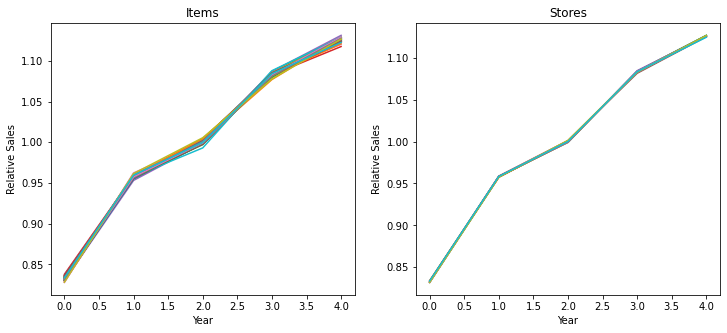

All items and stores seem to enjoy a similar growth in sales over the years.


In [32]:
agg_year_item = pd.pivot_table(df, index='year', columns='item',
                               values='sales', aggfunc=np.mean).values
agg_year_store = pd.pivot_table(df, index='year', columns='store',
                                values='sales', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_year_item / agg_year_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Year")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_year_store / agg_year_store.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Year")
plt.ylabel("Relative Sales")
plt.show()
print("All items and stores seem to enjoy a similar growth in sales over the years.")

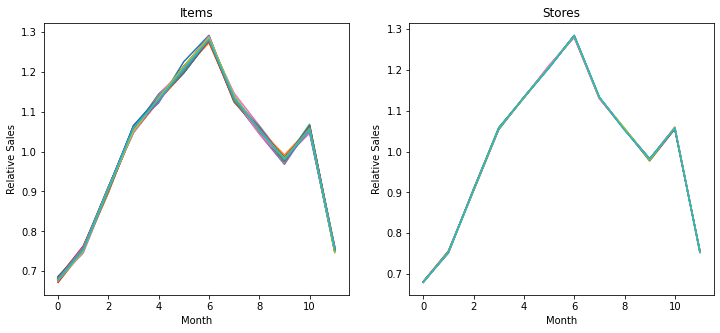

All items and stores seem to share a common pattern in sales over the months as well.


In [33]:
agg_month_item = pd.pivot_table(df, index='month', columns='item',
                                values='sales', aggfunc=np.mean).values
agg_month_store = pd.pivot_table(df, index='month', columns='store',
                                 values='sales', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_month_item / agg_month_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Month")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_month_store / agg_month_store.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Month")
plt.ylabel("Relative Sales")
plt.show()
print("All items and stores seem to share a common pattern in sales over the months as well.")

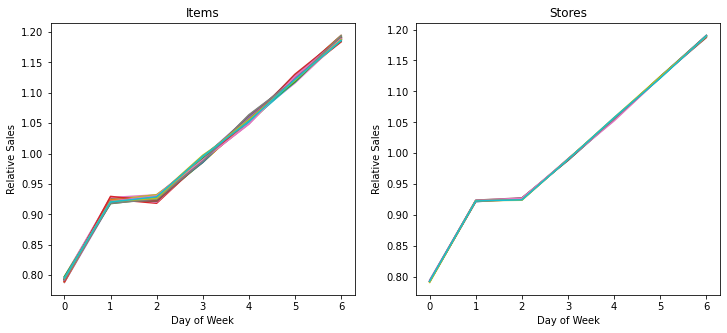

All items and stores also seem to share a common pattern in sales over the days of the week as well.


In [35]:
agg_dow_item = pd.pivot_table(df, index='day_of_week', columns='item',
                              values='sales', aggfunc=np.mean).values
agg_dow_store = pd.pivot_table(df, index='day_of_week', columns='store',
                               values='sales', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_dow_item / agg_dow_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_dow_store / agg_dow_store.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.show()
print("All items and stores also seem to share a common pattern in sales over the days of the week as well.")



<ipython-input-92-ab8bfa5f2d31>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(121)


<AxesSubplot:title={'center':'Items'}, xlabel='Day of Week', ylabel='Relative Sales'>

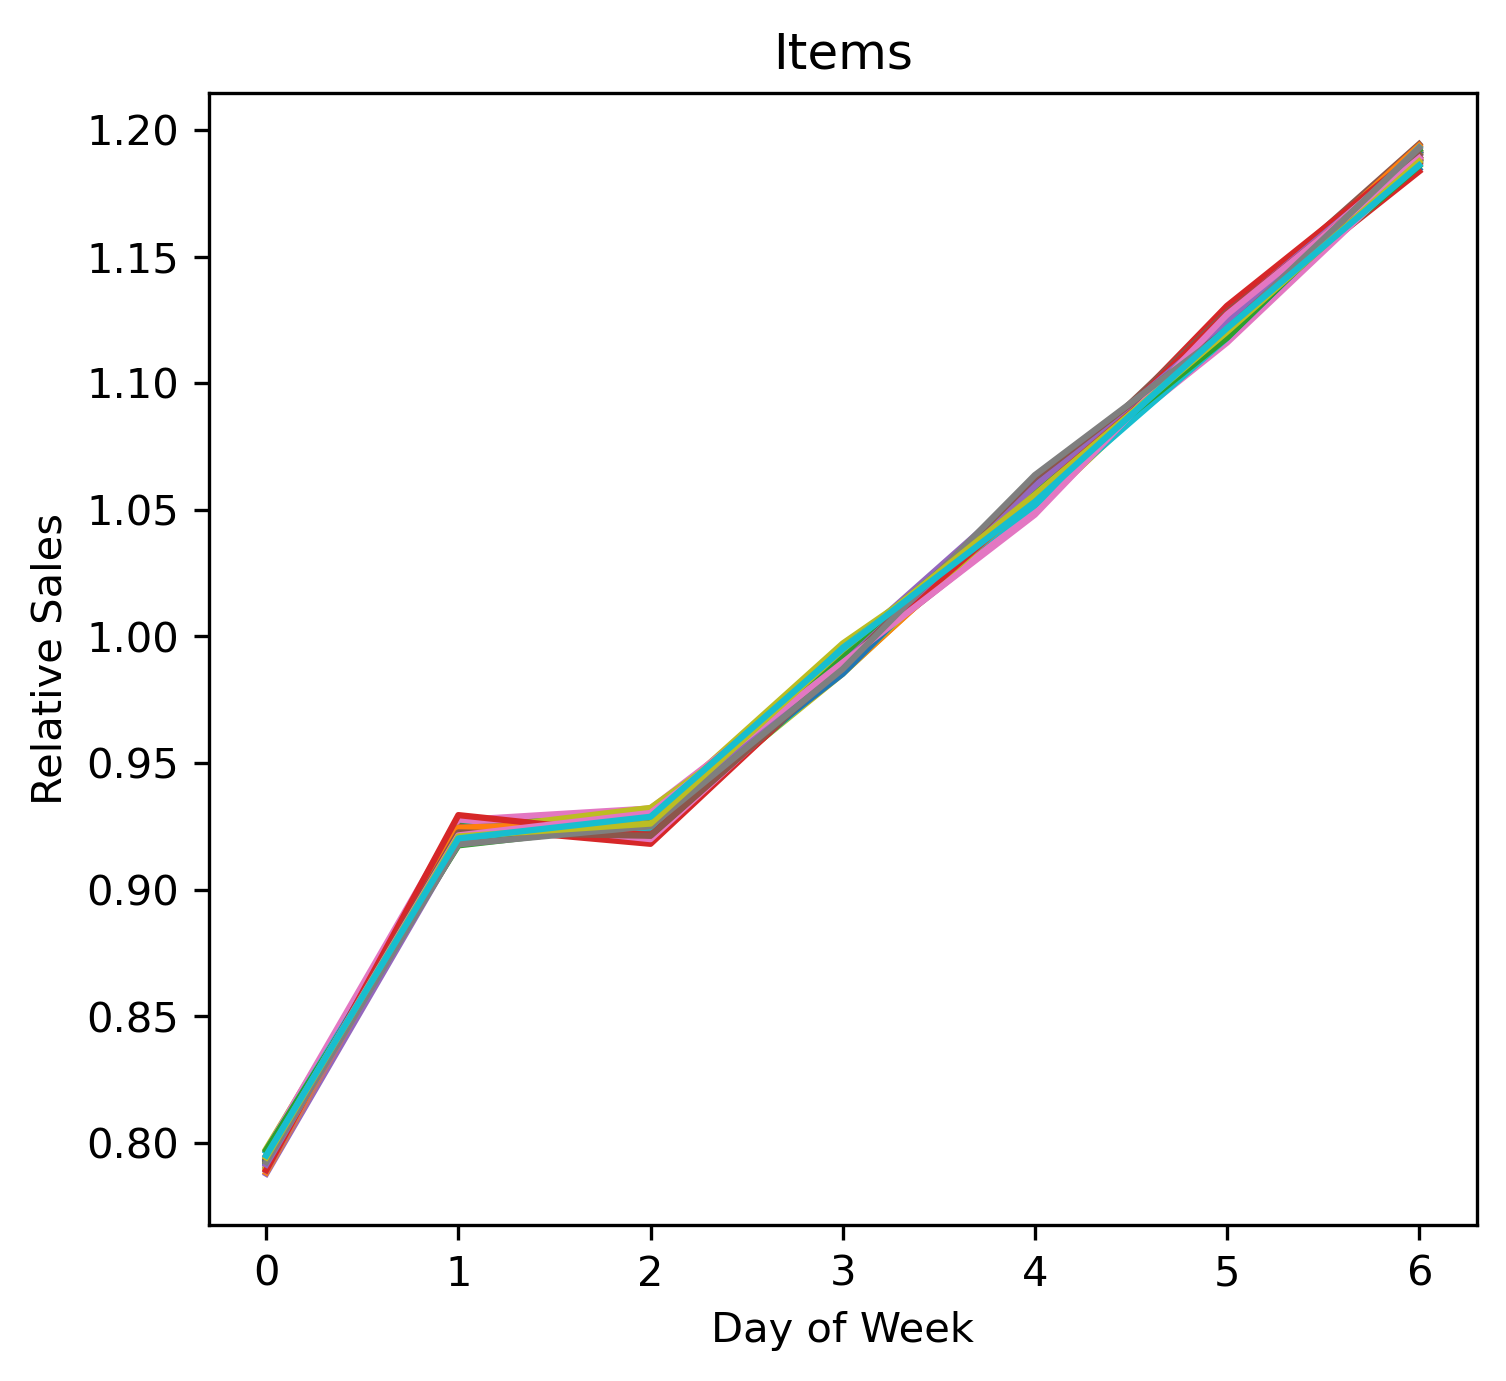

In [92]:
agg_dow_item = pd.pivot_table(df, index='day_of_week', columns='item',
                              values='sales', aggfunc=np.mean).values
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_dow_item / agg_dow_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.subplot(121)

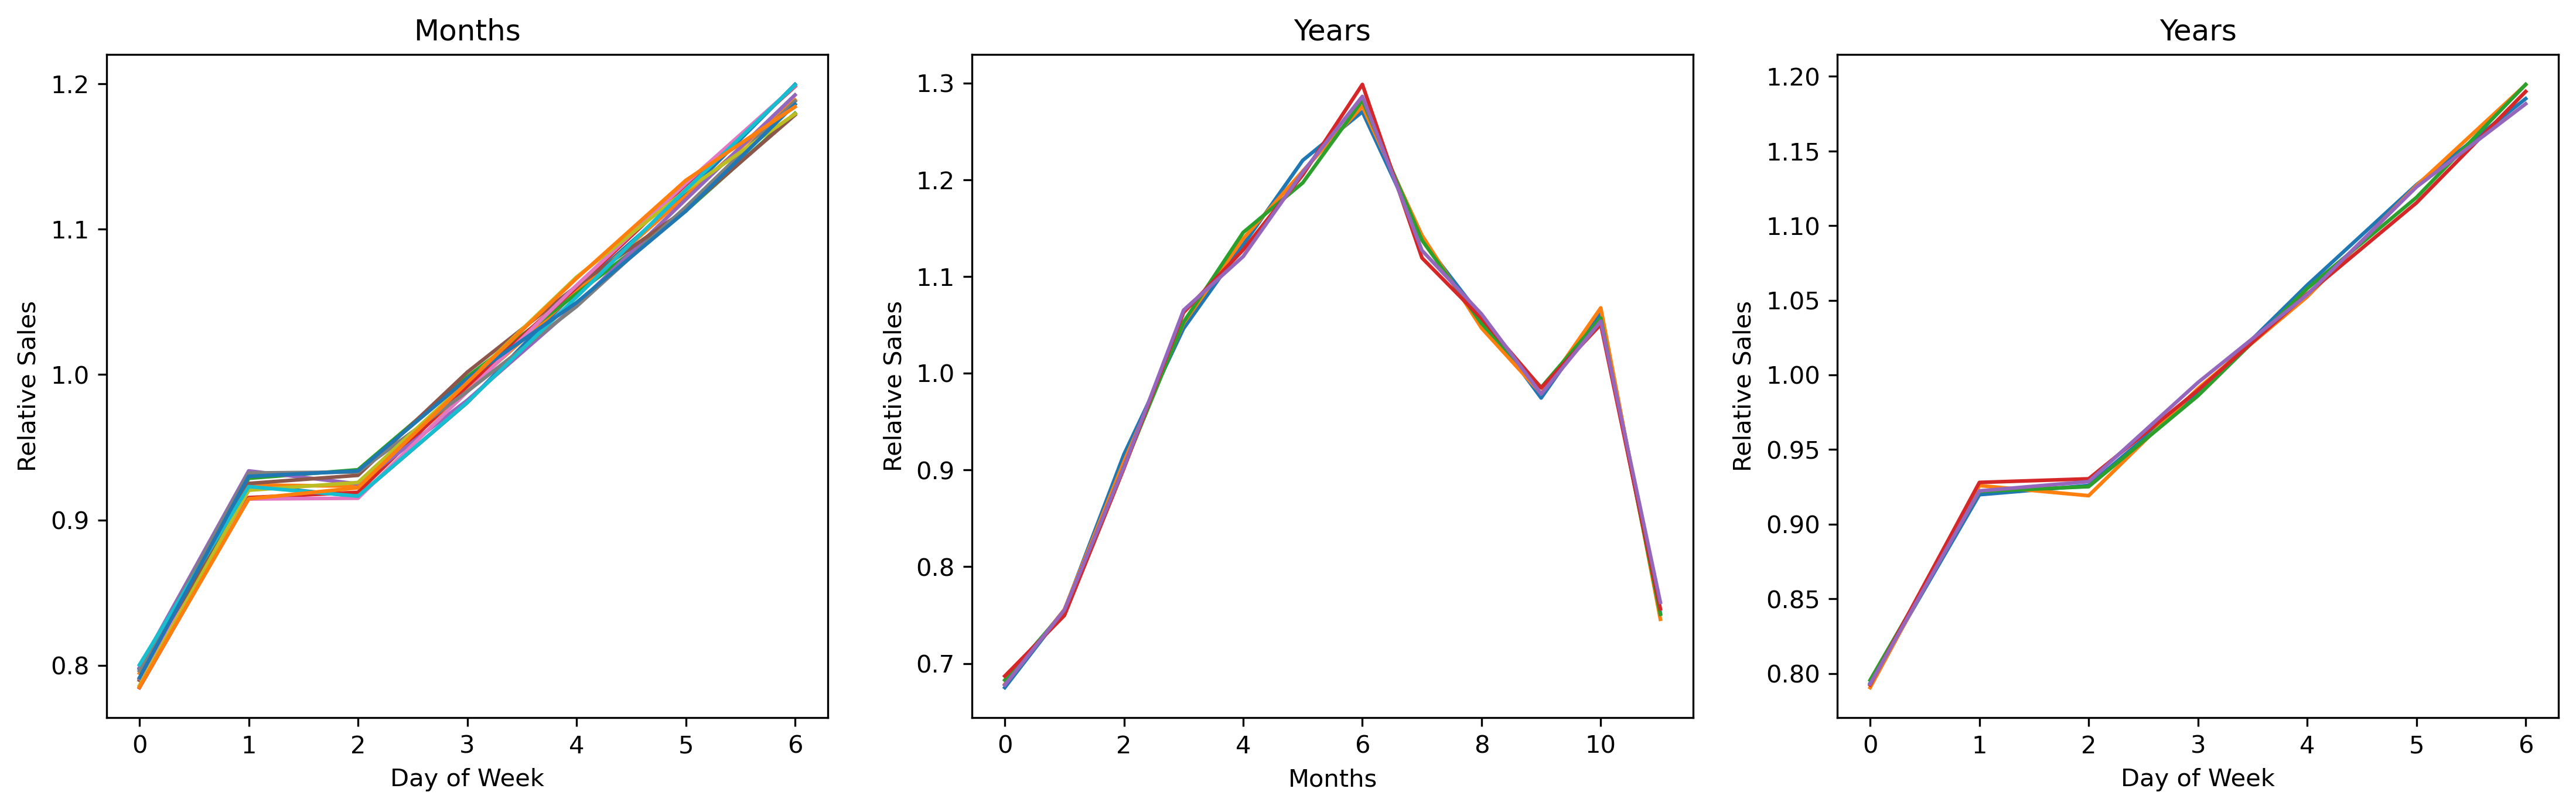

In [93]:
agg_dow_month = pd.pivot_table(df, index='day_of_week', columns='month',
                               values='sales', aggfunc=np.mean).values
agg_month_year = pd.pivot_table(df, index='month', columns='year',
                                values='sales', aggfunc=np.mean).values
agg_dow_year = pd.pivot_table(df, index='day_of_week', columns='year',
                              values='sales', aggfunc=np.mean).values

plt.figure(figsize=(18, 5))
plt.subplot(131)
plt.plot(agg_dow_month / agg_dow_month.mean(0)[np.newaxis])
plt.title("Months")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.subplot(132)
plt.plot(agg_month_year / agg_month_year.mean(0)[np.newaxis])
plt.title("Years")
plt.xlabel("Months")
plt.ylabel("Relative Sales")
plt.subplot(133)
plt.plot(agg_dow_year / agg_dow_year.mean(0)[np.newaxis])
plt.title("Years")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.show()

In [43]:
df.head()

,date,store,item,sales,year,month,day_of_year,week_of_year,day_of_week,is_wknd,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,daily_avg,monthly_avg,store_item_shifted_365,item-week_shifted_90
0,2013-01-01,1,1,13,2013,1,1,1,1,1,1,0,True,False,True,False,18,13.709677,30,4882
1,2013-01-02,1,1,11,2013,1,2,1,2,2,0,0,False,False,False,False,18,13.709677,13,4882
2,2013-01-03,1,1,14,2013,1,3,1,3,3,0,0,False,False,False,False,19,13.709677,11,4882
3,2013-01-04,1,1,13,2013,1,4,1,4,4,0,0,False,False,False,False,21,13.709677,14,4882
4,2013-01-05,1,1,10,2013,1,5,1,5,5,0,0,False,False,False,False,22,13.709677,13,4882


In [44]:
df=df.drop('date', axis=1)
df.head()

,store,item,sales,year,month,day_of_year,week_of_year,day_of_week,is_wknd,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,daily_avg,monthly_avg,store_item_shifted_365,item-week_shifted_90
0,1,1,13,2013,1,1,1,1,1,1,0,True,False,True,False,18,13.709677,30,4882
1,1,1,11,2013,1,2,1,2,2,0,0,False,False,False,False,18,13.709677,13,4882
2,1,1,14,2013,1,3,1,3,3,0,0,False,False,False,False,19,13.709677,11,4882
3,1,1,13,2013,1,4,1,4,4,0,0,False,False,False,False,21,13.709677,14,4882
4,1,1,10,2013,1,5,1,5,5,0,0,False,False,False,False,22,13.709677,13,4882


In [45]:
y = df['sales'].values
X = df.drop(['sales'], axis = 1) 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state=1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(730400, 18) (730400,) (182600, 18) (182600,)


In [51]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [52]:
y_pred = regressor.predict(X_test)
   
y_pred1 = y_pred
y_pred1 = y_pred1.reshape(-1,1)
   
print("\n   RESULT OF LINEAR REGRESSION PREDICTION : ")
print ("\nFirst 10 Predicted value : \n", y_pred1[0:10, :])


   RESULT OF LINEAR REGRESSION PREDICTION : 

First 10 Predicted value : 
 [[63.23459531]
 [29.95114595]
 [21.56773027]
 [52.37239207]
 [18.40073136]
 [81.17362572]
 [80.24607261]
 [25.6626054 ]
 [30.67553393]
 [92.53890968]]


In [96]:
from sklearn import linear_model 
from sklearn.metrics import mean_absolute_error, r2_score

In [97]:
print('Mean absolute error test: %.2f'% mean_absolute_error(y_test, pred_test))
print('Mean absolute error train: %.2f'% mean_absolute_error(y_train, pred_train))

NameError: name 'pred_test' is not defined

In [54]:
print('R-Squared test: %.2f'% r2_score(y_test, pred_test))
print('R-Squared train: %.2f'% r2_score(y_train, pred_train))


NameError: name 'r2_score' is not defined

In [56]:
correlation_matrix = df.corr().round(2)

<AxesSubplot:>

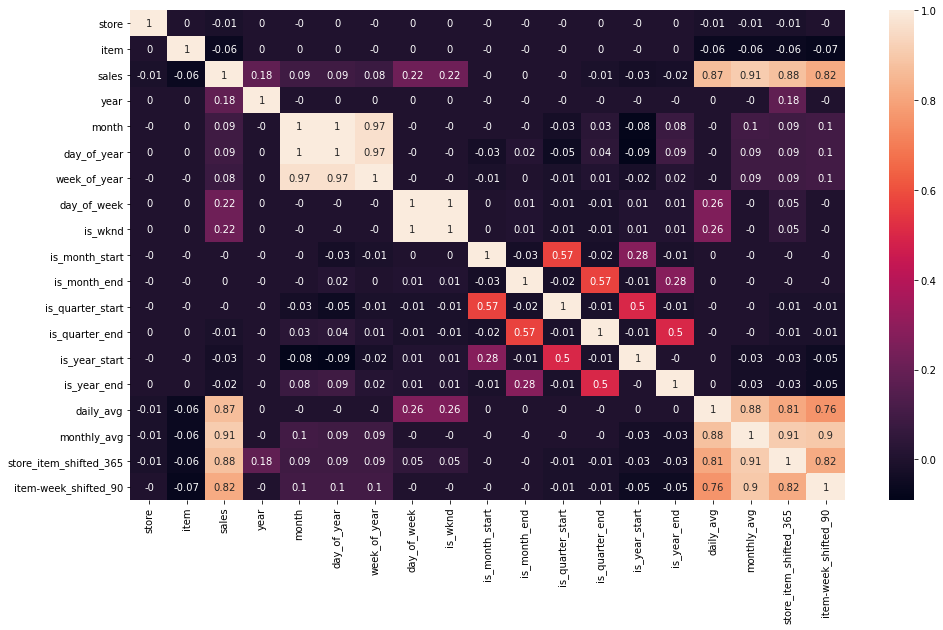

In [58]:
plt.figure(figsize=(16,9))
sns.heatmap(data=correlation_matrix, annot=True)

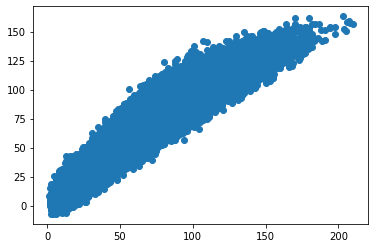

In [60]:
plt.scatter(y_test, y_pred)
plt.show()

In [62]:
from xgboost import XGBRegressor
reg = XGBRegressor(n_estimators=500, learning_rate=0.01)
reg.fit(X_train, 
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='mae')

[0]	validation_0-mae:51.22485	validation_1-mae:51.24932
[1]	validation_0-mae:50.71493	validation_1-mae:50.73783
[2]	validation_0-mae:50.20792	validation_1-mae:50.22851
[3]	validation_0-mae:49.71176	validation_1-mae:49.72606
[4]	validation_0-mae:49.21164	validation_1-mae:49.22948
[5]	validation_0-mae:48.71444	validation_1-mae:48.73682
[6]	validation_0-mae:48.23269	validation_1-mae:48.25037
[7]	validation_0-mae:47.74871	validation_1-mae:47.76638
[8]	validation_0-mae:47.26734	validation_1-mae:47.28915
[9]	validation_0-mae:46.79710	validation_1-mae:46.81688
[10]	validation_0-mae:46.32677	validation_1-mae:46.34914
[11]	validation_0-mae:45.87050	validation_1-mae:45.88612
[12]	validation_0-mae:45.41244	validation_1-mae:45.42545
[13]	validation_0-mae:44.95329	validation_1-mae:44.97138
[14]	validation_0-mae:44.50703	validation_1-mae:44.52199
[15]	validation_0-mae:44.05986	validation_1-mae:44.07611
[16]	validation_0-mae:43.62197	validation_1-mae:43.63551
[17]	validation_0-mae:43.18351	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [75]:
predictions = reg.predict(X_test)
X.head()

,store,item,sales,year,month,day_of_year,week_of_year,day_of_week,is_wknd,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,daily_avg,monthly_avg,store_item_shifted_365,item-week_shifted_90,predictions
0,1,1,13,2013,1,1,1,1,1,1,0,True,False,True,False,18,13.709677,30,4882,63.656528
1,1,1,11,2013,1,2,1,2,2,0,0,False,False,False,False,18,13.709677,13,4882,18.410938
2,1,1,14,2013,1,3,1,3,3,0,0,False,False,False,False,19,13.709677,11,4882,21.056530
3,1,1,13,2013,1,4,1,4,4,0,0,False,False,False,False,21,13.709677,14,4882,46.843254
4,1,1,10,2013,1,5,1,5,5,0,0,False,False,False,False,22,13.709677,13,4882,18.895155


In [76]:
X =df.reset_index().drop('index', axis=1)
X['predictions'] = pd.Series(predictions)
X.head()

,store,item,sales,year,month,day_of_year,week_of_year,day_of_week,is_wknd,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,daily_avg,monthly_avg,store_item_shifted_365,item-week_shifted_90,predictions
0,1,1,13,2013,1,1,1,1,1,1,0,True,False,True,False,18,13.709677,30,4882,63.656528
1,1,1,11,2013,1,2,1,2,2,0,0,False,False,False,False,18,13.709677,13,4882,18.410938
2,1,1,14,2013,1,3,1,3,3,0,0,False,False,False,False,19,13.709677,11,4882,21.056530
3,1,1,13,2013,1,4,1,4,4,0,0,False,False,False,False,21,13.709677,14,4882,46.843254
4,1,1,10,2013,1,5,1,5,5,0,0,False,False,False,False,22,13.709677,13,4882,18.895155


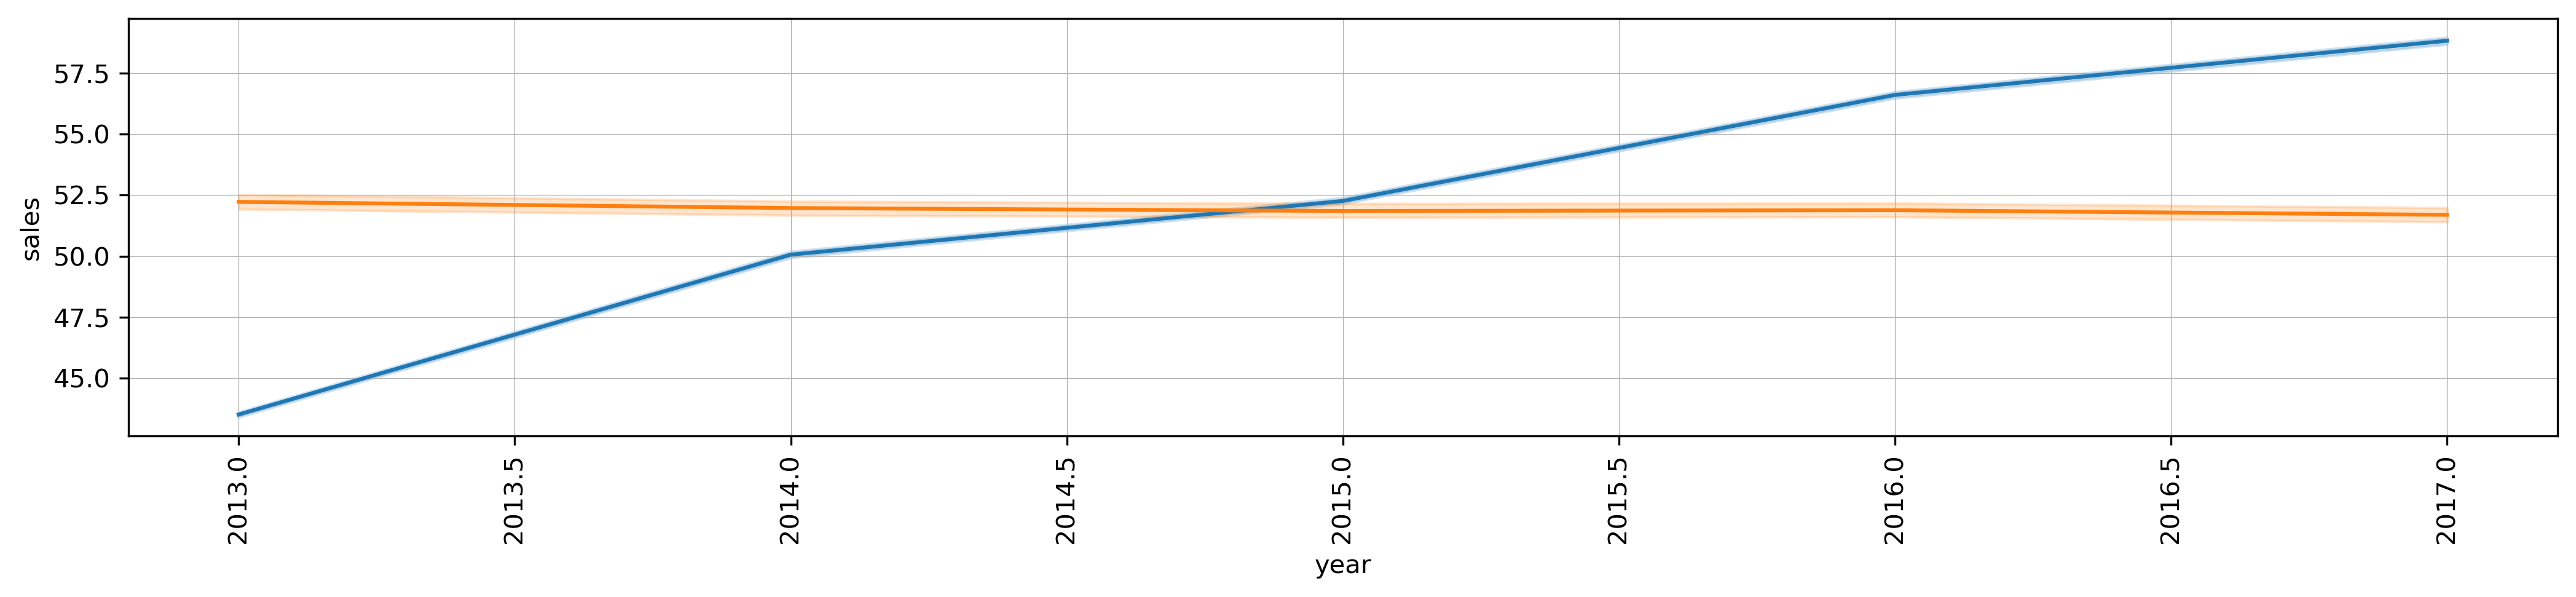

In [74]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=X, x='year', y='sales')
sns.lineplot(data=X, x='year', y='predictions')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [85]:
df.head()

,store,item,sales,year,month,day_of_year,week_of_year,day_of_week,is_wknd,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,daily_avg,monthly_avg,store_item_shifted_365,item-week_shifted_90
0,1,1,13,2013,1,1,1,1,1,1,0,True,False,True,False,18,13.709677,30,4882
1,1,1,11,2013,1,2,1,2,2,0,0,False,False,False,False,18,13.709677,13,4882
2,1,1,14,2013,1,3,1,3,3,0,0,False,False,False,False,19,13.709677,11,4882
3,1,1,13,2013,1,4,1,4,4,0,0,False,False,False,False,21,13.709677,14,4882
4,1,1,10,2013,1,5,1,5,5,0,0,False,False,False,False,22,13.709677,13,4882


<AxesSubplot:xlabel='item'>

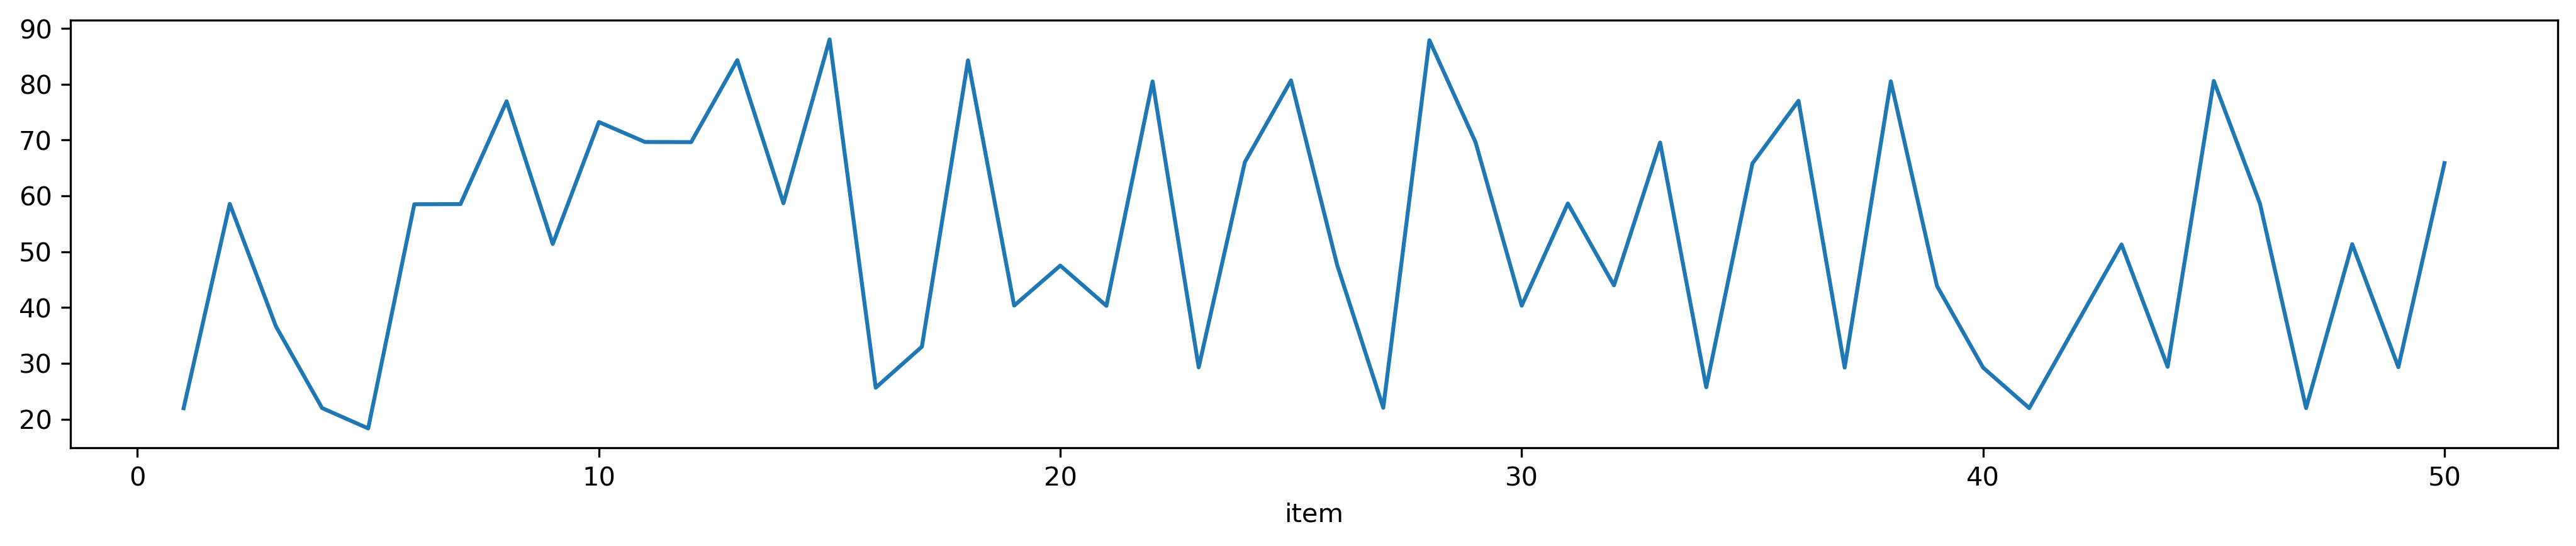

In [88]:
df.groupby("item")["sales"].mean().plot()


In [ ]:
y = df['sales'].values
X = df.drop(['sales'], axis = 1) 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state=1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = X = df.drop(['sales'], axis = 1)
y = y = df['sales'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=111)
scaler.fit(X_train) # compute mu and sigma
X_train = scaler.transform(X_train)


In [101]:
def XGBmodel(X_train,x_test,y_train,y_test):
    matrix_train = xgb.DMatrix(X_train,label=y_train)
    matrix_test = xgb.DMatrix(X_test,label=y_test)
    model=xgb.train(params={'objective':'reg:squarederror','eval_metric':'mae'}
                  ,dtrain=matrix_train,num_boost_round=500, 
                    early_stopping_rounds=20,evals=[(matrix_test,'test')],)
    return model
model=XGBmodel(X_train,X_test,y_train,y_test)

[0]	test-mae:36.23599
[1]	test-mae:25.38730
[2]	test-mae:17.85495
[3]	test-mae:12.78618
[4]	test-mae:9.58201
[5]	test-mae:7.71374
[6]	test-mae:6.69757
[7]	test-mae:6.16881
[8]	test-mae:5.90064
[9]	test-mae:5.76570
[10]	test-mae:5.69655
[11]	test-mae:5.66118
[12]	test-mae:5.64319
[13]	test-mae:5.63249
[14]	test-mae:5.62626
[15]	test-mae:5.62198
[16]	test-mae:5.62000
[17]	test-mae:5.61829
[18]	test-mae:5.61648
[19]	test-mae:5.61501
[20]	test-mae:5.61327
[21]	test-mae:5.61200
[22]	test-mae:5.61143
[23]	test-mae:5.60971
[24]	test-mae:5.60862
[25]	test-mae:5.60785
[26]	test-mae:5.60667
[27]	test-mae:5.60636
[28]	test-mae:5.60590
[29]	test-mae:5.60547
[30]	test-mae:5.60536
[31]	test-mae:5.60424
[32]	test-mae:5.60363
[33]	test-mae:5.60368
[34]	test-mae:5.60416
[35]	test-mae:5.60296
[36]	test-mae:5.60292
[37]	test-mae:5.60260
[38]	test-mae:5.60197
[39]	test-mae:5.60196
[40]	test-mae:5.60103
[41]	test-mae:5.59976
[42]	test-mae:5.59980
[43]	test-mae:5.59968
[44]	test-mae:5.59956
[45]	test-mae:5.

ValueError: Could not interpret value `sales` for parameter `y`

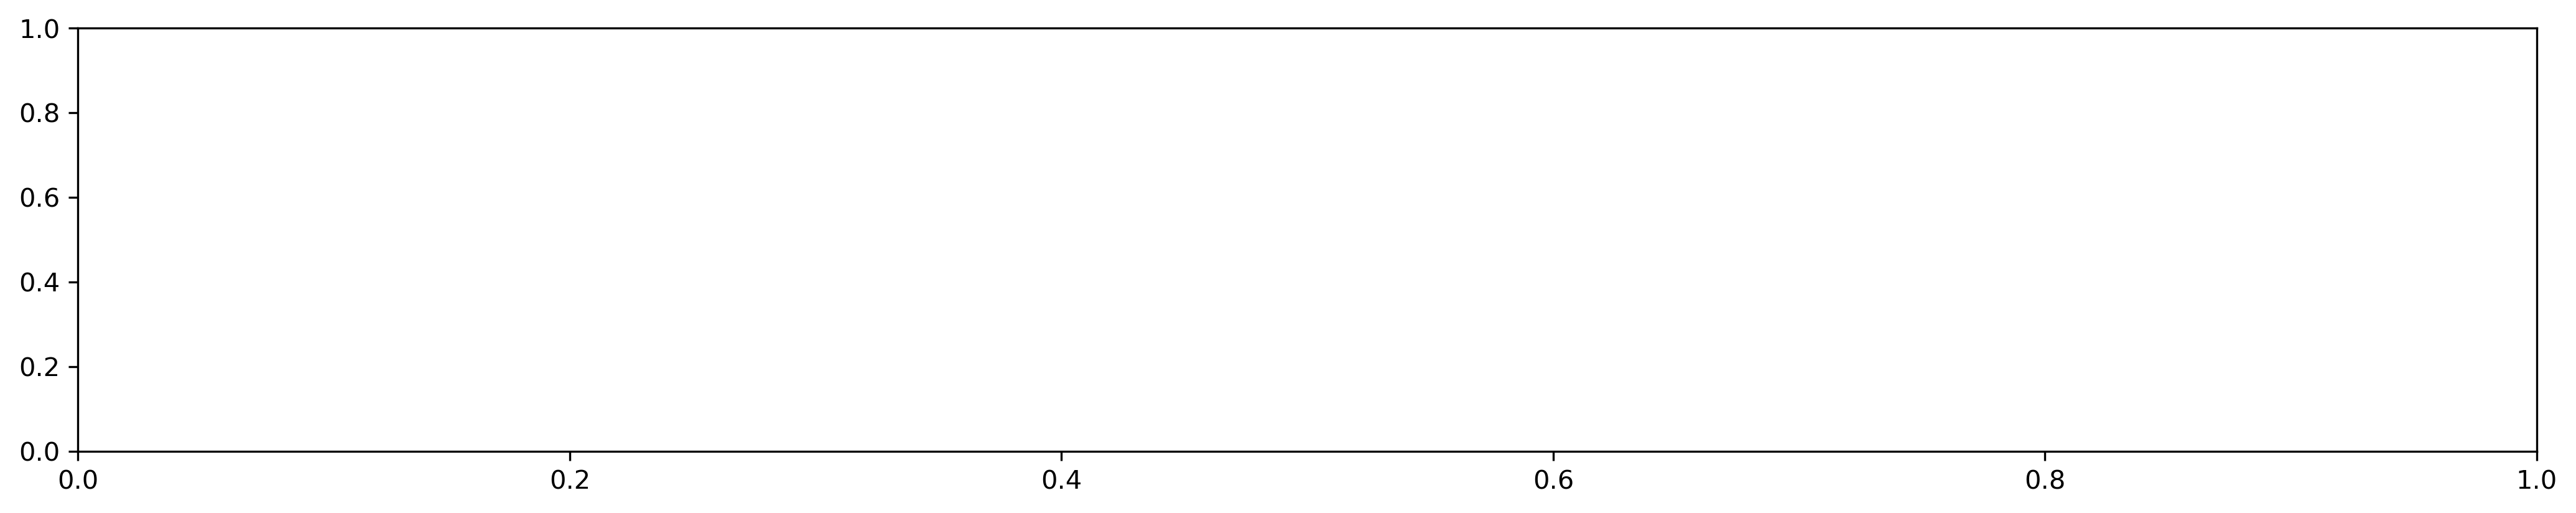

In [105]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=X, x='year', y='sales')
sns.lineplot(data=X, x='year', y='predictions')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [115]:
np.shape(y_pred)
np.shape(y_train)

#f=np.max(y_pred-y_train,0).reshape(2,2)
#g=np.max(y_train-y_pred,0).reshape(2,2)
#f.shape
#g.shape

(730400,)